<a id=contents></a>

# Extraction and cleaning notebook
## Data retrieved from glassdoor.com

Data was extracted via Glassdoor's REST API (documentation here: https://www.glassdoor.com/developer/index.htm). 

[1. Data Inspection](#insp)

[2. Cleaning text data](#text)

In [26]:
import pandas as pd
import os
import time
import requests as req
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)
import bs4
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

Now that we have a list of strings, we can check the length, the size of string and what the most frequent terms will be, which'll give us an insight into what we need to clean.

In [3]:
ds_jobs = pd.read_pickle('ds_jobs_raw.pickle')
ds_jobs.head()

,company,job_titles_lst,job_descr,job_post_html,job_search_term,job_url
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",data scientist,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",data scientist,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",data scientist,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...


In [4]:
ds_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company          666 non-null    object
 1   job_titles_lst   666 non-null    object
 2   job_descr        666 non-null    object
 3   job_post_html    666 non-null    object
 4   job_search_term  666 non-null    object
 5   job_url          666 non-null    object
dtypes: object(6)
memory usage: 31.3+ KB


In [5]:
ds_jobs.job_descr.nunique()

545

In [6]:
ds_jobs.job_url.nunique()

666

It's very odd that we'd see different numbers of duplicates between the two columnns. Given that it's the text we're most interested in, we're gonna drop duplicates via the job description column first.

In [7]:
ds_jobs.drop_duplicates(inplace=True, subset='job_descr')

In [8]:
ds_jobs.shape

(545, 6)

In [9]:
ds_jobs.head()

,company,job_titles_lst,job_descr,job_post_html,job_search_term,job_url
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",data scientist,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",data scientist,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",data scientist,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...


In [108]:
ds_jobs.rename(columns={'job_titles_lst':'job_title'}, inplace=True)
ds_jobs.head()

,company,job_title,job_descr,job_post_html,job_search_term,job_url,is_mleng
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",data scientist,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,0
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,0
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",data scientist,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,0
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",data scientist,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,0
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",data scientist,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,0


Important to give the frequency of terms a quick gland and see what is dominating our vocabulary. At this basic EDA stage we can pick up a lot of the unclean data.

In [109]:
final_str = []
job_descr_list = [text for text in ds_jobs.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])
f_dist

FreqDist({'and': 12294, 'the': 7866, 'data': 4330, 'with': 3342, 'you': 2960, 'for': 2846, 'our': 2280, 'experience': 1994, 'will': 1673, 'learning': 1623, ...})

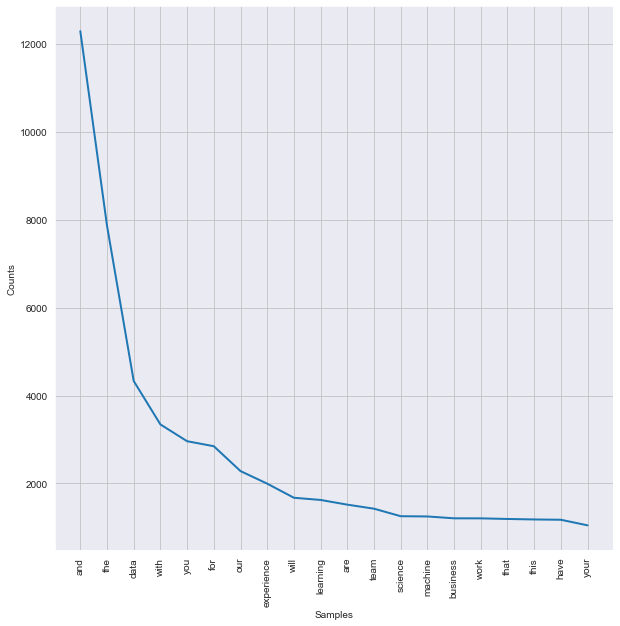

In [110]:
plt.figure(figsize=(10,10))
f_dist.plot(20);

Now let's see what our data would look like without stop words.

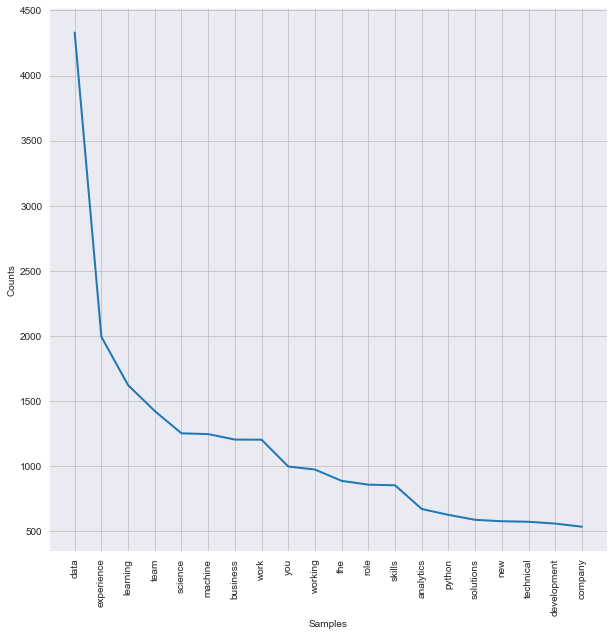

In [111]:
final_str = []
job_descr_list = [text for text in ds_jobs.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        if token not in stop_words:
            final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])

plt.figure(figsize=(10,10))
f_dist.plot(20);

Ok, so with this distribution in mind it seems that we're getting much, much cleaner data and our tokenizer seems to have parsed through a lot of potential rubbish. A good question would be whether we want to include 'data' or not. For the purpose of comparing later to the ML Eng data, let's keep it in. We will now explore the ML Eng data similarly. 

In [112]:
mleng_jobs = pd.read_pickle('mleng_jobs_raw.pkl')
print(mleng_jobs.nunique())
mleng_jobs.head()

company            298
job_title          559
job_descr          680
job_post_html      812
job_search_term      1
job_url            812
dtype: int64


,company,job_title,job_descr,job_post_html,job_search_term,job_url
0,Spotify59 reviews,Machine Learning Engineer – Search,The Personalization team makes deciding what t...,"[[[\n, <title>Machine Learning Engineer – Sear...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=adc2d336aec...
1,Transformative AI,Research Scientist - Machine Learning,ABOUT TRANSFORMATIVEBorn out of CERN and the U...,"[[[\n, <title>Research Scientist - Machine Lea...",machine learning engineer,https://www.indeed.co.uk/company/Transformativ...
2,Echobox,Junior Machine Learning Engineer - London,Echobox has access to very large granular priv...,"[[[\n, <title>Junior Machine Learning Engineer...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=110484a7c65...
3,OakNorth Bank,"Engineer, Machine Learning",OakNorth is the next-generation credit and mon...,"[[[\n, <title>Engineer, Machine Learning - Lon...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=4c460bbd6a3...
4,NP Group,Machine Learning Scientist,Machine Learning Scientist - London - Investme...,"[[[\n, <title>Machine Learning Scientist - Lon...",machine learning engineer,https://www.indeed.co.uk/rc/clk?jk=6f06b212bad...


In [113]:
mleng_jobs.drop_duplicates('job_descr', inplace=True)

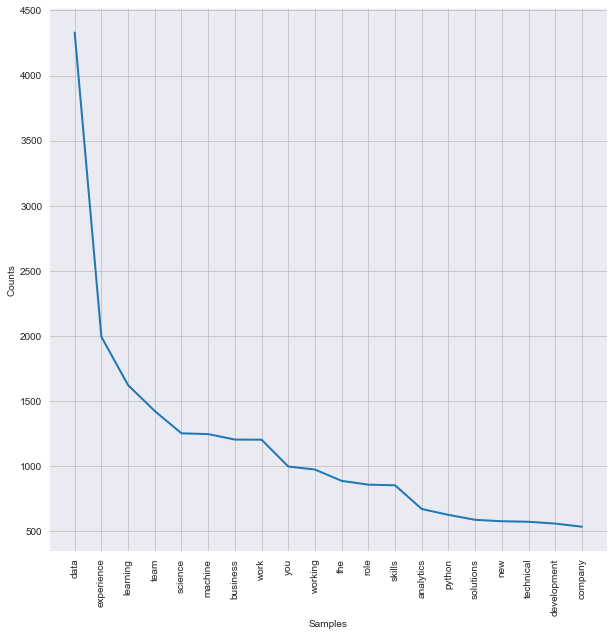

In [114]:
final_str = []
job_descr_list = [text for text in ds_jobs.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        if token not in stop_words:
            final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])
plt.figure(figsize=(10,10))
f_dist.plot(20);

We'll merge the data sets now, but adding a categorical column for ML engineering job posts. A value of 1 means the job came up in the ML Engineering job search.

In [246]:
df = pd.concat([ds_jobs, mleng_jobs], axis=0)
df.shape

(1225, 7)

In [247]:
df.nunique()

company             450
job_title           810
job_descr          1065
job_post_html      1225
job_search_term       2
job_url            1049
is_mleng              1
dtype: int64

So ultimately we have 1065 unique job posts after dropping duplicates within both categories.
As we would have expected we have some job posts that came up in both searches. Since the URL and job_search_term variables can track which came from where, we will leave them in for now and look at them later in more detail.

In [248]:
df.drop(columns=['is_mleng'], inplace=True)
merged_jobs = pd.get_dummies(df, columns=['job_search_term'], prefix='searched_')


In [249]:
merged_jobs.head()

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0


In [250]:
merged_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 705
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   company                              1225 non-null   object
 1   job_title                            1225 non-null   object
 2   job_descr                            1225 non-null   object
 3   job_post_html                        1225 non-null   object
 4   job_url                              1225 non-null   object
 5   searched__data scientist             1225 non-null   uint8 
 6   searched__machine learning engineer  1225 non-null   uint8 
dtypes: object(5), uint8(2)
memory usage: 59.8+ KB


Let's have a look at the job dom and see if we can extract any additional info from there.

In [251]:
testsoup = BeautifulSoup(str(merged_jobs.job_post_html[7].values[0]), 'html')
testsoupstr = testsoup.get_text()
salary_tokenizer = RegexpTokenizer('£[0-9]+,[0-9]+')
salaries = salary_tokenizer.tokenize(testsoupstr)
salaries

['£55,000', '£80,000', '£55,000', '£80,000', '£55,000', '£80,000']

In [269]:
def get_salary(dom):
    dom = str(dom)
    soup = BeautifulSoup(dom, 'html')
    soup_str = soup.get_text()
    salary_tokenizer = RegexpTokenizer('£[0-9]+,[0-9]+')
    salaries = salary_tokenizer.tokenize(soup_str)
#     if isinstance(salaries,list):
#         try:
#             return salaries[0]
#         except:
#             return salaries
#     else:
    return salaries

In [253]:
(merged_jobs.job_post_html[1].values[0])

<html dir="ltr" lang="en" xmlns="http://www.w3.org/1999/xhtml"><head>
<title>Deals - Investigative Analytics - Data Scientist - London - London - Indeed.co.uk</title><meta charset="utf-8"/><meta content="ie=edge" http-equiv="x-ua-compatible"/><meta content="notranslate" name="google"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="noindex" name="robots"/><meta content="http://www.indeed.co.uk/viewjob?from=appsharedroid&amp;jk=7548e60a487de4b8" id="indeed-share-url"/><meta content="Deals - Investigative Analytics - Data Scientist - London" id="indeed-share-message"/><meta content="simple" id="indeed-share-type"/><script async="" src="https://www.google-analytics.com/plugins/ua/linkid.js" type="text/javascript"></script><script async="" src="https://sb.scorecardresearch.com/beacon.js"></script><script async="" src="https://www.google-analytics.com/analytics.js"></script><script src="https://d3fw5vlhllyvee.cloudfront.net/mosaic-common/dist/2156f5a9e015

In [254]:
l = get_salary(merged_jobs.job_post_html[0])
l

['£39,853', '£39,853']

In [255]:
for i in range(0,100):
    print(get_salary(merged_jobs.job_post_html[i]))

['£39,853', '£39,853']
[]
[]
[]
['£35,846', '£35,846', '£35,846', '£3,339', '£2,800', '£80,000', '£100,000', '£80,000', '£100,000']
[]
[]
['£55,000', '£80,000', '£55,000', '£80,000', '£55,000', '£80,000']
['£22,000', '£25,000', '£22,000', '£25,000', '£22,000', '£25,000', '£24,477', '£35,165', '£24,477', '£35,165', '£24,477', '£35,165']
[]
['£40,000', '£70,000', '£40,000', '£70,000', '£40,000', '£70,000']
[]
['£75,000', '£95,000', '£75,000', '£95,000', '£75,000', '£95,000']
[]
[]
[]
['£35,000', '£60,000', '£35,000', '£60,000']
['£50,000', '£65,000', '£50,000', '£65,000', '£90,000', '£110,000', '£90,000', '£110,000']
[]
[]
[]
['£70,000', '£80,000', '£70,000', '£80,000', '£70,000', '£80,000']
[]
['£50,000', '£70,000', '£50,000', '£70,000', '£50,000', '£70,000']
[]
[]
[]
[]
[]
['£35,000', '£50,000', '£35,000', '£50,000']
['£25,000', '£25,000']
[]
['£120,000', '£180,000', '£120,000', '£180,000']
['£120,000', '£140,000', '£120,000', '£140,000', '£120,000', '£120,000']
['£70,000', '£80,000', 

In [256]:
len([])

0

In [266]:
merged_jobs_reset = merged_jobs.reset_index(drop=True)

In [270]:
merged_jobs_reset['salary_from_page_source'] = 'nan'
for i in range(len(merged_jobs_reset)):
    salary = get_salary(merged_jobs_reset.job_post_html[i])
    print(salary)
    if len(salary)>1:
        merged_jobs_reset['salary_from_page_source'][i] = salary[0]
    elif len(salary)==0:
        merged_jobs_reset['salary_from_page_source'][i] = 'nan'
    else:
        merged_jobs_reset['salary_from_page_source'][i] = salary
        
    


['£39,853', '£39,853']
[]
[]
[]
['£35,846', '£35,846', '£35,846', '£3,339', '£2,800']
[]
[]
['£55,000', '£80,000', '£55,000', '£80,000', '£55,000', '£80,000']
['£22,000', '£25,000', '£22,000', '£25,000', '£22,000', '£25,000']
[]
[]
[]
['£75,000', '£95,000', '£75,000', '£95,000', '£75,000', '£95,000']
[]
[]
[]
[]
['£50,000', '£65,000', '£50,000', '£65,000']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['£25,000', '£25,000']
[]
[]
[]
[]
[]
['£45,000', '£60,000', '£45,000', '£60,000', '£45,000', '£60,000']
['£100,000', '£125,000', '£100,000', '£125,000', '£100,000', '£125,000']
['£70,000', '£80,000', '£70,000', '£80,000', '£70,000', '£80,000']
['£60,000', '£80,000', '£60,000', '£80,000']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['£50,000', '£60,000', '£50,000', '£60,000', '£50,000', '£60,000']
[]
[]
[]
[]
[]
[]
['£70,000', '£85,000', '£70,000', '£85,000', '£70,000', '£85,000']
[]
[]
[]
['£6,000']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['£70,000', '£90,000', '£70,000', '£90,000', '£90,000', '£90,000']
[]
[]
[]
['£90,0

In [271]:
merged_jobs_reset.head(10)

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer,salary_from_page_source
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,We would like to reassure all applicants that ...,"[[[\n, <title>CPRD Data Scientist - London - I...",https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,"£39,853"
1,"PwC7,678 reviews",Deals - Investigative Analytics - Data Scienti...,"A career within Forensics Technology services,...","[[[\n, <title>Deals - Investigative Analytics ...",https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,nan
2,"Capital One - UK8,902 reviews",Data Scientist - Cyber,"White Collar Factory (95009), United Kingdom, ...","[[[\n, <title>Data Scientist - Cyber - London ...",https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,nan
3,Globant,Lead Data Scientist,We are a digitally native technology services ...,"[[[\n, <title>Lead Data Scientist - London EC1...",https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,nan
4,UK Government - National Crime Agency32 reviews,G4 Lead Data Scientist - Cyber,Deploy analytical capabilities in support of o...,"[[[\n, <title>G4 Lead Data Scientist - Cyber -...",https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,"£35,846"
5,"Deutsche Bank2,894 reviews",Artificial Intelligence – Data Scientist,Job Title: Artificial Intelligence – Data Scie...,"[[[\n, <title>Artificial Intelligence – Data S...",https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,1,0,nan
6,COLLAB. Recruitment Ltd,Data Scientist,Data Scientist\n\nRole\nDo you want to make a ...,"[[[\n, <title>Data Scientist - London EC1V - I...",https://www.indeed.co.uk/rc/clk?jk=3b623080f2e...,1,0,nan
7,digital gut per Forfirm,Data Scientist,FORFIRM is answering real business challenges ...,"[[[\n, <title>Data Scientist - London - Indeed...",https://www.indeed.co.uk/company/digital-gut-p...,1,0,"£55,000"
8,Link Humans,Data Scientist,We are looking for a Data Scientist to join ou...,"[[[\n, <title>Data Scientist - London W1F - In...",https://www.indeed.co.uk/company/Link-Humans/j...,1,0,"£22,000"
9,Revolut8 reviews,Data Scientist - Retail · Customer Experience,ABOUT THE TEAM\nData sits at the heart of Revo...,"[[[\n, <title>Data Scientist - Retail · Custom...",https://www.indeed.co.uk/rc/clk?jk=48b3cb7d73a...,1,0,nan


In [273]:
merged_jobs_reset.tail()

,company,job_title,job_descr,job_post_html,job_url,searched__data scientist,searched__machine learning engineer,salary_from_page_source
1220,Cytora2 reviews,Senior Software Engineer,We are looking for an experienced Senior Softw...,"[[[\n, <title>Senior Software Engineer - Londo...",https://www.indeed.co.uk/rc/clk?jk=1abdbc95edf...,0,1,nan
1221,Callsign,Lead Data Engineer,Central London\nJob Description\nDesign and de...,"[[[\n, <title>Lead Data Engineer - London - In...",https://www.indeed.co.uk/rc/clk?jk=b2ae9fc43be...,0,1,nan
1222,Callsign,Senior Data Engineer,SENIOR DATA ENGINEER\nJob Description\nCallsig...,"[[[\n, <title>Senior Data Engineer - London - ...",https://www.indeed.co.uk/rc/clk?jk=2dbdd232ed5...,0,1,nan
1223,Next Link,Microsoft Azure Cloud Engineer,Microsoft Azure Cloud Engineer – Azure – Virtu...,"[[[\n, <title>Microsoft Azure Cloud Engineer -...",https://www.indeed.co.uk/rc/clk?jk=63cba359d8e...,0,1,nan
1224,Antidote12 reviews,Senior Software Engineer (Backend),Interested in joining an organisation that is ...,"[[[\n, <title>Senior Software Engineer (Backen...",https://www.indeed.co.uk/rc/clk?jk=ab8bcbd54ca...,0,1,nan


In [275]:
merged_jobs.salary_from_page_source.value_counts()

nan         1005
£50,000       32
£60,000       20
£80,000       20
£70,000       18
£75,000       12
£90,000       12
£35,000       12
£65,000       10
£40,000        8
£100,000       8
£45,000        8
£85,000        6
£25,000        6
£55,000        6
£72,400        4
£120,000       4
£30,000        4
£24,477        2
£39,853        2
£41,300        2
£32,000        2
£6,000         2
£22,000        2
£35,846        2
£34,090        2
£37,280        2
£97,000        2
£110,000       2
£60,231        2
£150,000       2
£140,000       2
£95,000        2
Name: salary_from_page_source, dtype: int64

<a id=text ><a/> 

## 2. Cleaning text data
    
[LINK to table of contents](#contents)
    
We will preprocess the text data by removing any emails, websites and lemmatizing our text.

In [99]:
stop_words += list(string.punctuation)
lemmy = WordNetLemmatizer()


In [105]:
def preprocess_data(string):
    """As a precautionary measure we should try to remove any emails or websites that BS4 missed"""
    new_str = re.sub(r"\S+@\S+", '', string)
    new_str = re.sub(r"\S+.co\S+", '', new_str)
    new_str = re.sub(r"\S+.ed\S+", '', new_str)
    new_str_tok = tokenizer.tokenize(new_str)
    new_str_lemm = [lemmy.lemmatize(token) for token in new_str_tok]
    new_str_cont = ''
    for tok in new_str_lemm:
        new_str_cont += tok + ' '
    return new_str_cont

In [108]:
df.job_descr = df.job_descr.apply(preprocess_data)

In [109]:
df.head()

,job_url,job_descr,is_mleng
0,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,would like reassure all applicant that recruit...,0
1,https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,Job Title Artificial Intelligence Data Scienti...,0
2,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,career within Forensics Technology service wil...,0
3,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,White Collar Factory 95009 United Kingdom Lond...,0
4,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,are digitally native technology where innovati...,0


Before unloading the data we will do one final visualization of the whole dataframe's text.

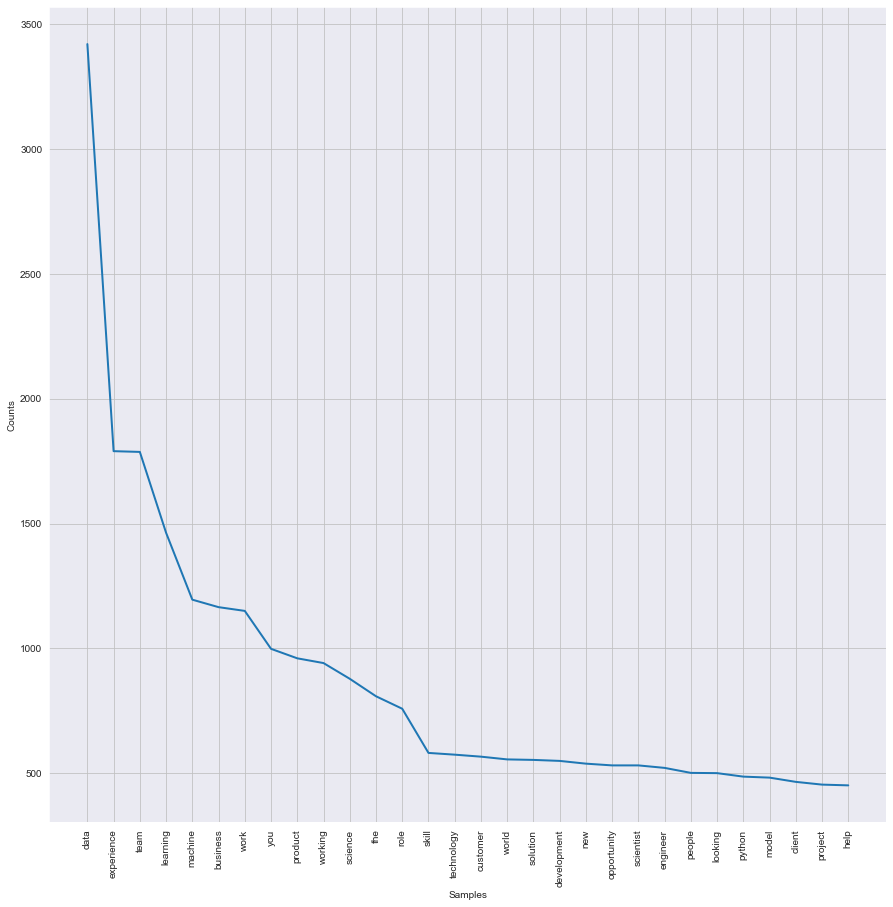

In [110]:
final_str = []
job_descr_list = [text for text in df.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        if token not in stop_words:
            final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])
plt.figure(figsize=(15,15))
f_dist.plot(30);

In [112]:
# All seems good!

df.to_pickle('clean_data.pkl')